# System Demo

## Imports

In [1]:
import torch
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2
from project.utils import compute_statistics
from project.model import RPN, ISAVIT, Feeder
import random
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns 

## Config Initialization

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### ISA-RPN configs

In [3]:
image_size = 300
patch_size = 32

In [4]:
rpn = RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        global_context=True,
        nh=4,
        pretrained=True
    ).to(device)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
rpn.load_state_dict(torch.load('fold/Nov_20_2024_225758/fold_1/rpn_fold1.pt'))

<All keys matched successfully>

### Feeder

In [6]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)

### ISA-ViT configs

In [7]:
vit = ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=True,
    ).to(device)

In [8]:
vit.load_state_dict(torch.load('fold/Nov_22_2024_100528/fold_1/vit_fold1.pt'))

<All keys matched successfully>

## Dataset Loading

In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

### Target slices that have cmbs

In [10]:
positive_data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
positive_data.shape

(364, 9)

In [11]:
positive_cohort_1 = positive_data.query('cohort == 1').reset_index(drop=True)
positive_cohort_1.shape

(45, 9)

In [12]:
positive_cohort_3 = positive_data.query('cohort == 3').reset_index(drop=True)
positive_cohort_3.shape

(47, 9)

#### Test Case for Cohort 1

In [13]:
# random number ranging from 1 to shape of positive data in cohort 1 and skip 3 numbers before selecting
rand_num = random.randrange(1, positive_cohort_1.shape[0], 3)

test_case_1 = positive_cohort_1.loc[rand_num]
test_case_1

mri                     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
masks                   c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
stripped                c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
target                                                                 23
has_microbleed_case                                                     1
has_microbleed_slice                                                    1
cohort                                                                  1
max_value                                                      1011.27124
slices                                                                 35
Name: 31, dtype: object

#### Test Case for Cohort 3

In [14]:
# random number ranging from 1 to shape of positive data in cohort 3 and skip 3 numbers before selecting
rand_num = random.randrange(1, positive_cohort_3.shape[0], 3)

test_case_2 = positive_cohort_3.loc[rand_num]
test_case_2

mri                     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
masks                   c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
stripped                c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
target                                                                 26
has_microbleed_case                                                     1
has_microbleed_slice                                                    1
cohort                                                                  3
max_value                                                           241.0
slices                                                                 36
Name: 43, dtype: object

### Target slices that do not have cmbs

In [15]:
negative_data = data.query('has_microbleed_slice == 0').reset_index(drop=True)
negative_data.shape

(7622, 9)

In [16]:
negative_cohort_1 = negative_data.query('cohort == 1').reset_index(drop=True)
negative_cohort_1.shape

(340, 9)

In [17]:
negative_cohort_3 = negative_data.query('cohort == 3').reset_index(drop=True)
negative_cohort_3.shape

(1026, 9)

#### Test Case for Cohort 1

In [18]:
# random number ranging from 1 to shape of negative data in cohort 1 and skip 3 numbers before selecting
rand_num = random.randrange(1, negative_cohort_1.shape[0], 3)

test_case_3 = negative_cohort_1.loc[rand_num]
test_case_3

mri                     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
masks                   c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
stripped                c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
target                                                                 20
has_microbleed_case                                                     1
has_microbleed_slice                                                    0
cohort                                                                  1
max_value                                                      902.317871
slices                                                                 35
Name: 46, dtype: object

#### Test Case for Cohort 3

In [19]:
# random number ranging from 1 to shape of negative data in cohort 3 and skip 3 numbers before selecting
rand_num = random.randrange(1, negative_cohort_3.shape[0], 3)

test_case_4 = negative_cohort_3.loc[rand_num]
test_case_4

mri                     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
masks                   c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
stripped                c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
target                                                                 11
has_microbleed_case                                                     1
has_microbleed_slice                                                    0
cohort                                                                  3
max_value                                                           257.0
slices                                                                 39
Name: 511, dtype: object

## Test Cases Combined

### DataFrame of Test Cases

In [20]:
test_cases = [test_case_1, test_case_2, test_case_3, test_case_4]

test_cases = pd.DataFrame(test_cases)
test_cases = test_cases.reset_index(drop=True)
test_cases

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,23,1,1,1,1011.271240,35
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000,36
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,20,1,0,1,902.317871,35
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,0,3,257.000000,39


In [21]:
from sklearn.model_selection import train_test_split

def make_dataset(data,
                 cohort,
                 skull_stripped,
                 target_shape=(300, 300),
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating dataset for Cohort {cohort}\n'

    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=False,
        normalization=(global_min, global_max)
    )

    if skull_stripped == True:
        dataset = VALDODataset(
            cases=data.stripped.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    else:
        dataset = VALDODataset(
            cases=data.mri.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    return dataset

### Dataset made of Raw MRI

In [22]:
raw_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=False)
raw_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=False)

test_cases_dataset_raw = ConcatDataset([raw_dataset_cohort1, raw_dataset_cohort3])
test_cases_dataset_raw_dl = DataLoader(
    test_cases_dataset_raw,
    shuffle=False,
    batch_size=test_cases_dataset_raw.__len__(),
    collate_fn=collatev2
)

### Dataset made of Skull-stripped MRI

In [24]:
stripped_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=True)
stripped_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=True)

test_cases_dataset_stripped = ConcatDataset([stripped_dataset_cohort1, stripped_dataset_cohort3])
test_cases_dataset_stripped_dl = DataLoader(
    test_cases_dataset_stripped,
    shuffle=False,
    batch_size=test_cases_dataset_stripped.__len__(),
    collate_fn=collatev2
)

## Prediction using the model

In [26]:
def predict(loader, stage1, stage2, feeder):
    Y = []
    T = []
    cases = []
    targets = []
    bbox_predictions = []
    with torch.inference_mode():
        for batch in loader:
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
                masks = masks.float().to(device)
                bbox = stage1(slices, target)
                bbox = bbox * image_size
                bbox = bbox.squeeze().round().int().detach().cpu().numpy()

                x = feeder(slices, bbox, 32)
                t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(device)
                t = t.flatten(2).float().to(device)
                segmented_mask = stage2(x, target)

                Y.append(segmented_mask)
                T.append(t[target])
                cases.append(case)
                targets.append(target)
                bbox_predictions.append(bbox)

    return Y, T, cases, targets, bbox_predictions

In [27]:
predictions, ground_truths, cases, targets, bbox_predictions = predict(
    loader=test_cases_dataset_stripped_dl,
    stage1=rpn,
    stage2=vit,
    feeder=feeder
)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


## Visualizations

### Before Normalization and Resize

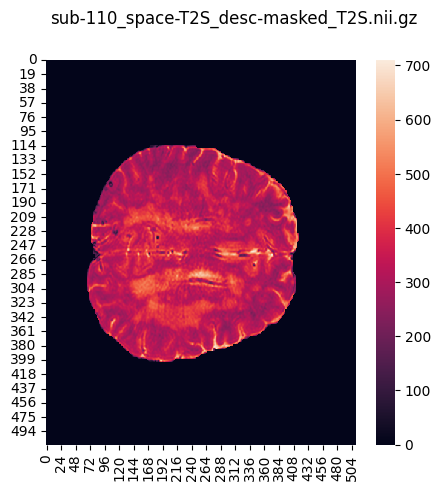

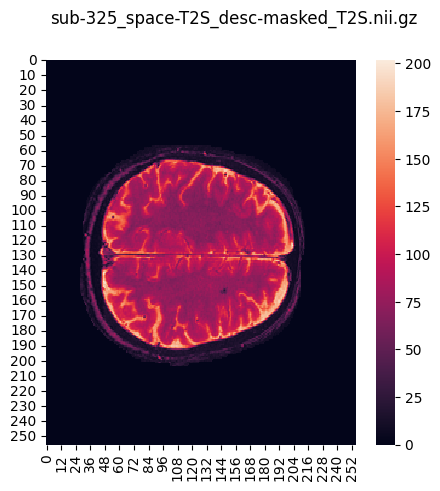

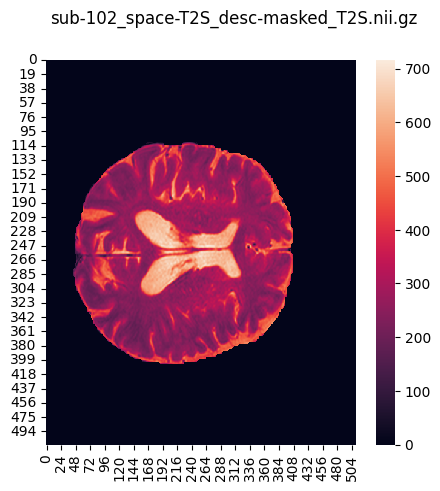

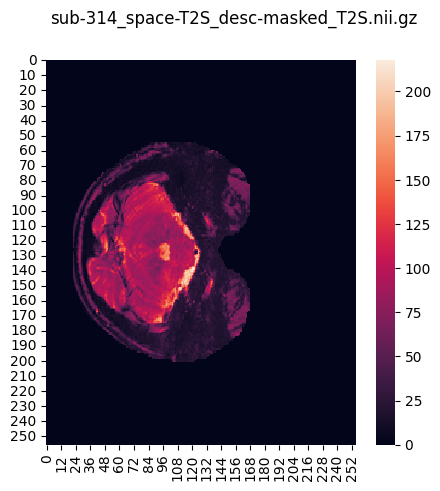

In [45]:
import nibabel as nib
import numpy as np
for i in range(test_cases.shape[0]):
    mri = nib.load(test_cases['mri'].loc[i]).get_fdata()
    mri = np.transpose(mri, (2, 0, 1))
    slice_index = test_cases['target'].loc[i]
    mri_slice = mri[slice_index]

    f, a = plt.subplots(1, 1, figsize=(5, 5))
    f.suptitle(test_cases['mri'].loc[i].split('\\')[-1])
    sns.heatmap(mri_slice, ax=a, vmax=np.max(mri_slice))
    plt.show()

### Raw MRI and Target Slice Visualization

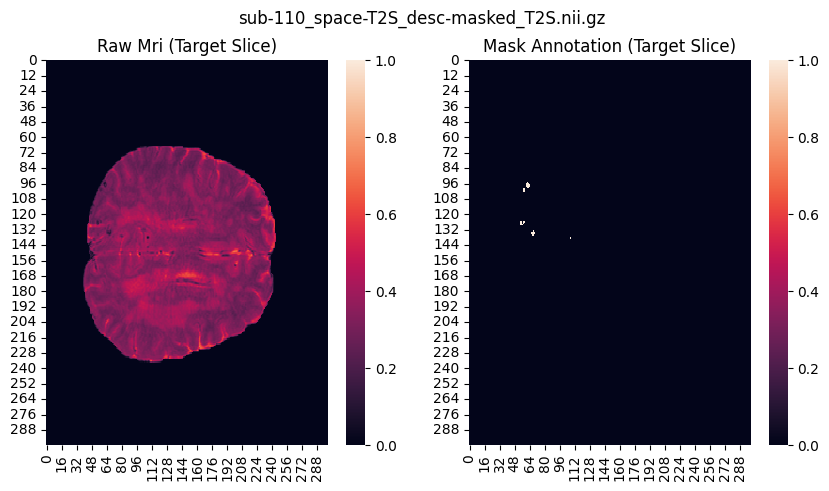

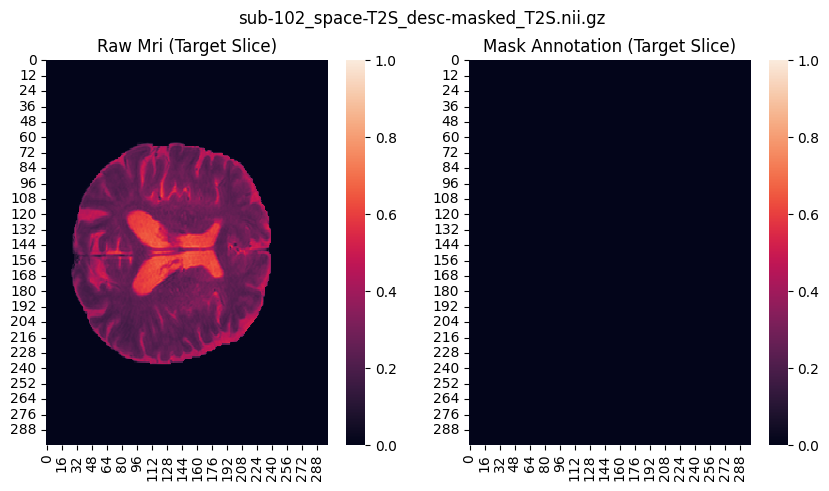

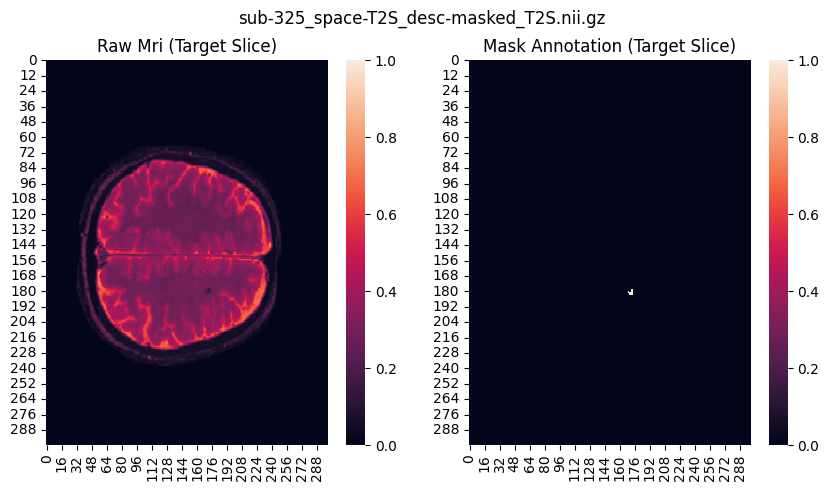

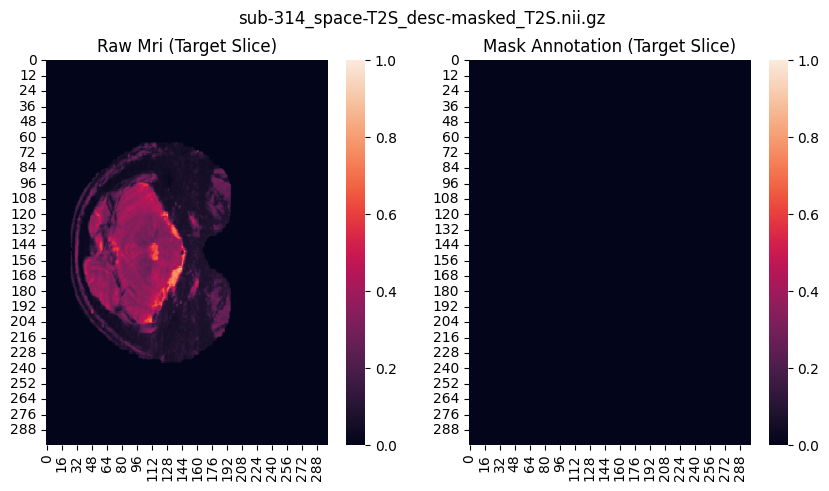

In [50]:
for batch in test_cases_dataset_raw_dl:
    for slices, masks, target, case in batch:
        f, a = plt.subplots(1, 2, figsize=(10, 5))
        f.suptitle(case.split('\\')[-1])
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax1.set_title('Raw Mri (Target Slice)')
        ax2.set_title('Mask Annotation (Target Slice)')
        sns.heatmap(slices[target].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(masks[target].squeeze(), ax=ax2, vmax=1)

### Skull-stripped MRI and Target Slice Visualization

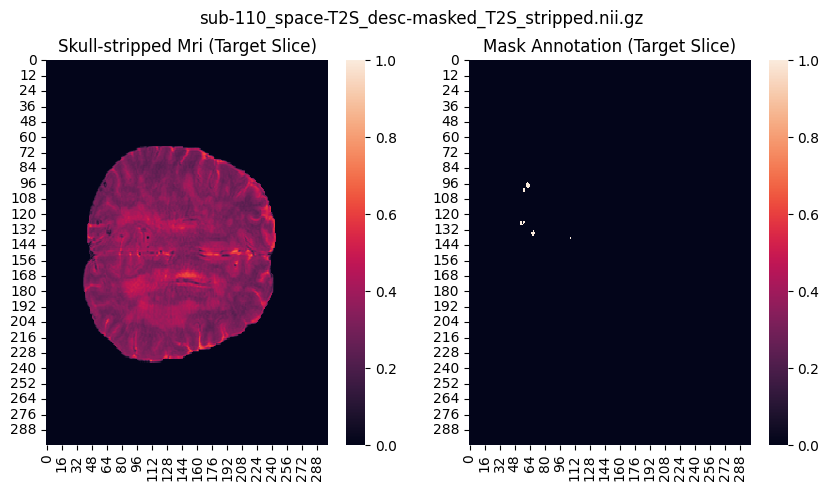

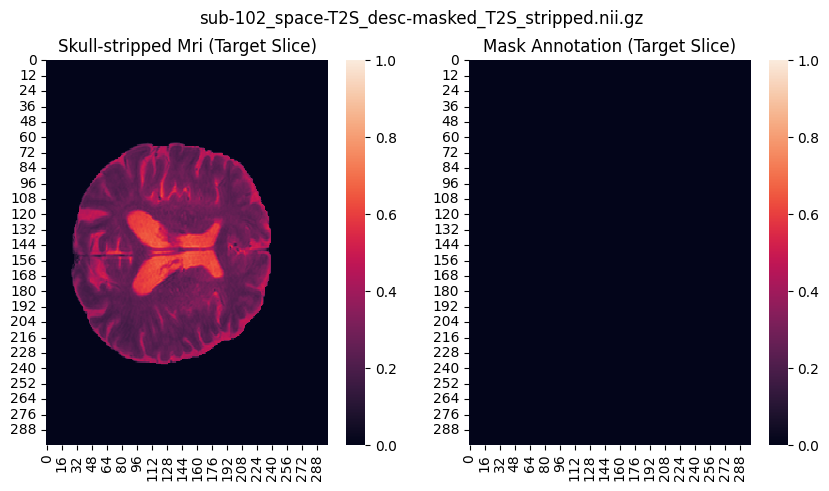

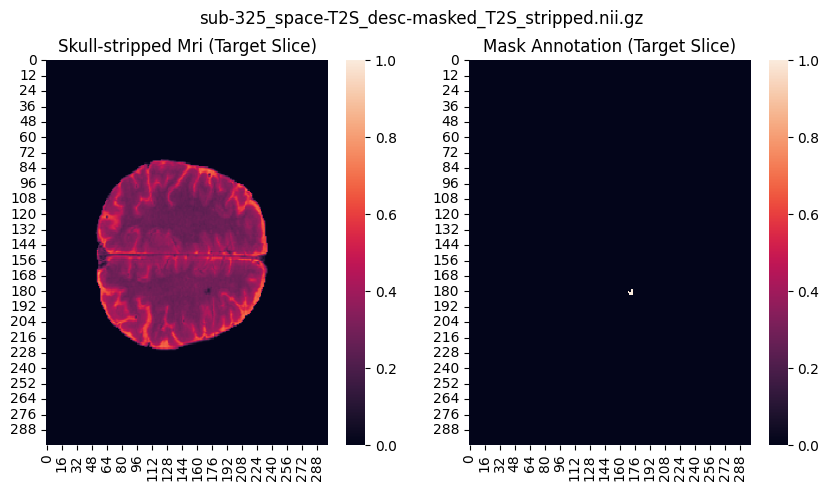

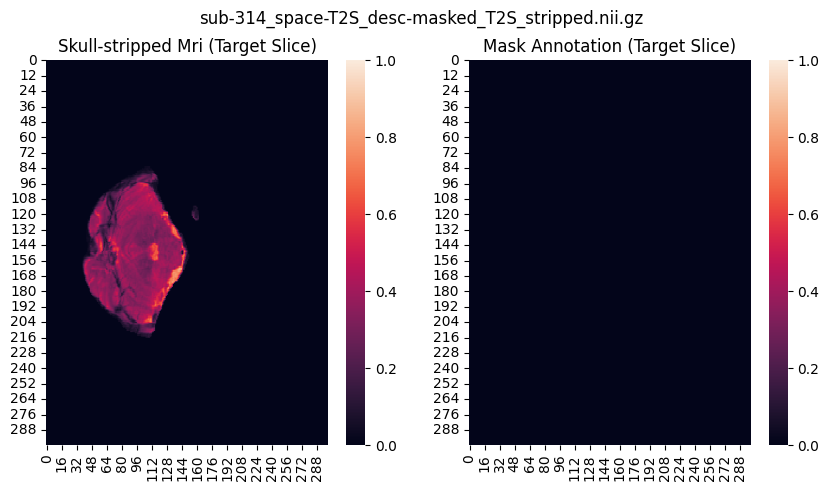

In [46]:
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        f, a = plt.subplots(1, 2, figsize=(10, 5))
        f.suptitle(case.split('\\')[-1])
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax1.set_title('Skull-stripped Mri (Target Slice)')
        ax2.set_title('Mask Annotation (Target Slice)')
        sns.heatmap(slices[target].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(masks[target].squeeze(), ax=ax2, vmax=1)

### Cropped Target slice for MRI and Mask Annotation

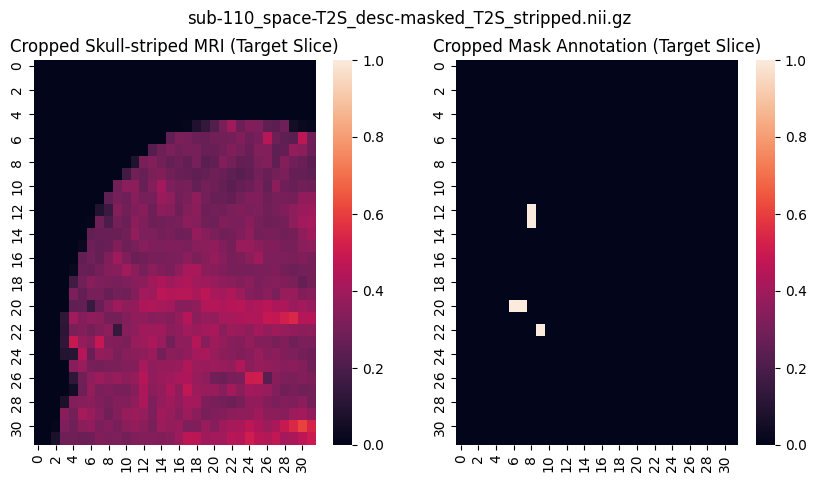

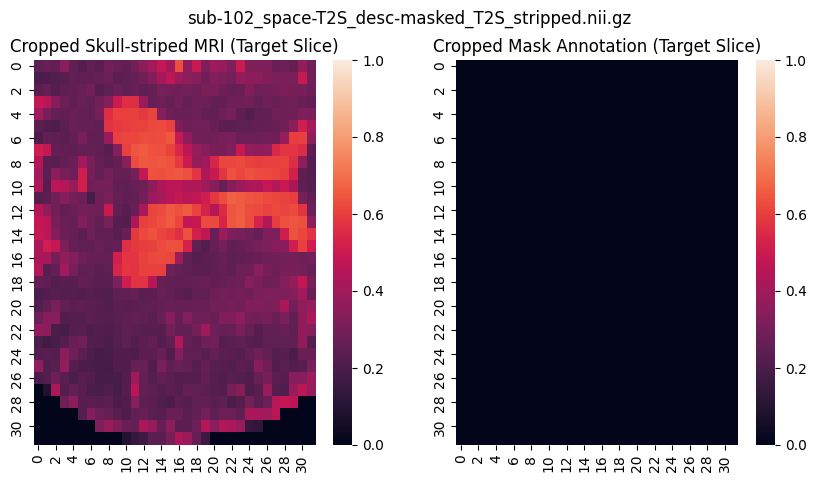

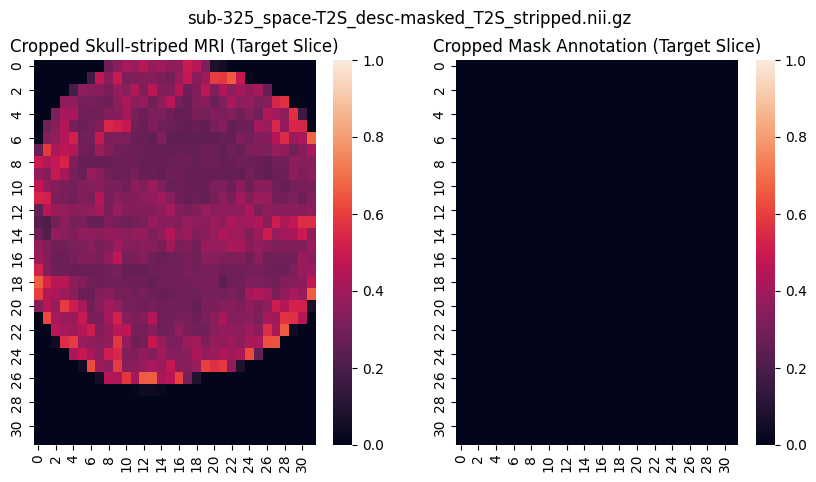

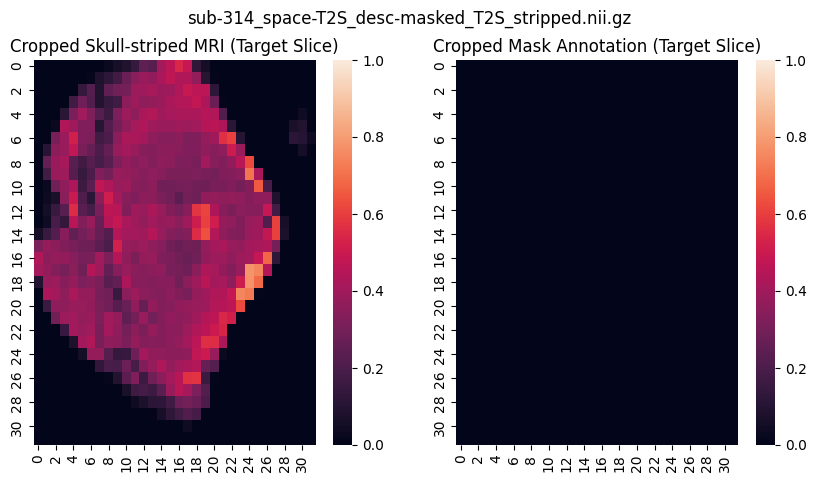

In [51]:
i = 0
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:

        cropped_slices = feeder(slices, bbox_predictions[i], 32)
        cropped_masks = feeder(masks, bbox_predictions[i], 32)
        i += 1
        
        f, a = plt.subplots(1, 2, figsize=(10, 5))
        f.suptitle(case.split('\\')[-1])
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax1.set_title('Cropped Skull-striped MRI (Target Slice)')
        ax2.set_title('Cropped Mask Annotation (Target Slice)')
        sns.heatmap(cropped_slices[target].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(cropped_masks[target].squeeze(), ax=ax2, vmax=1)

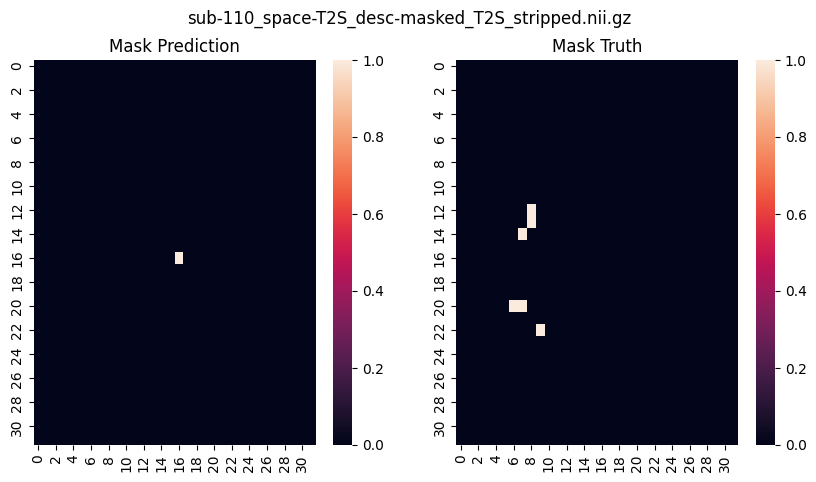

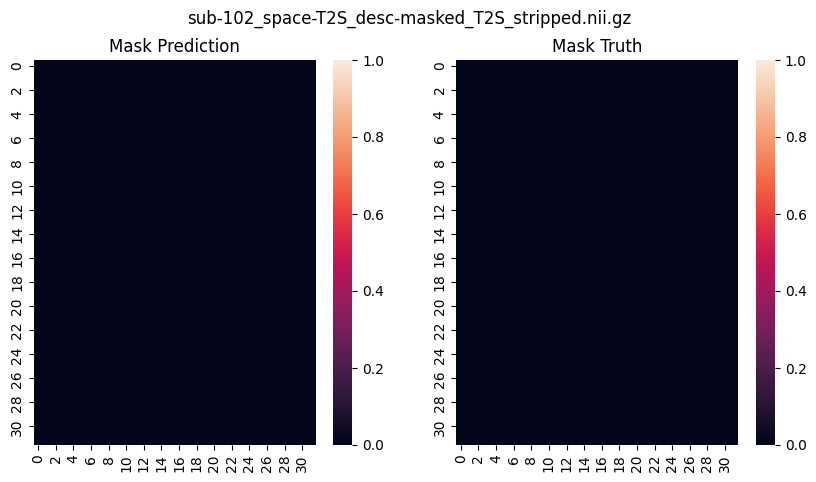

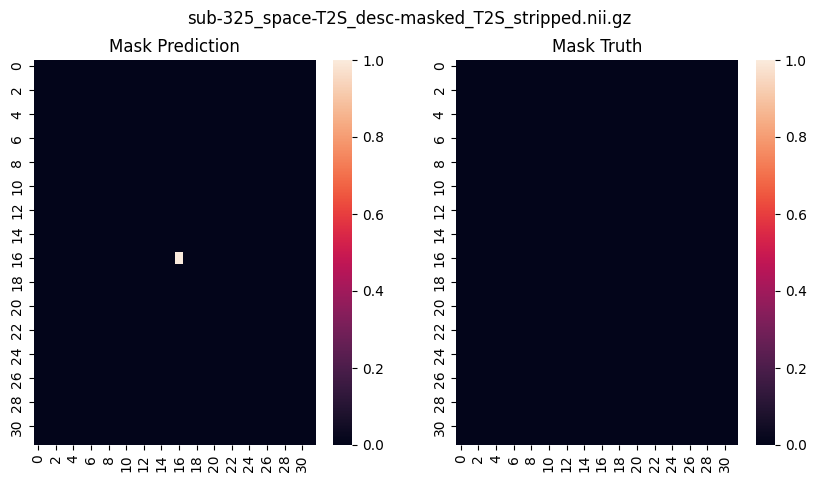

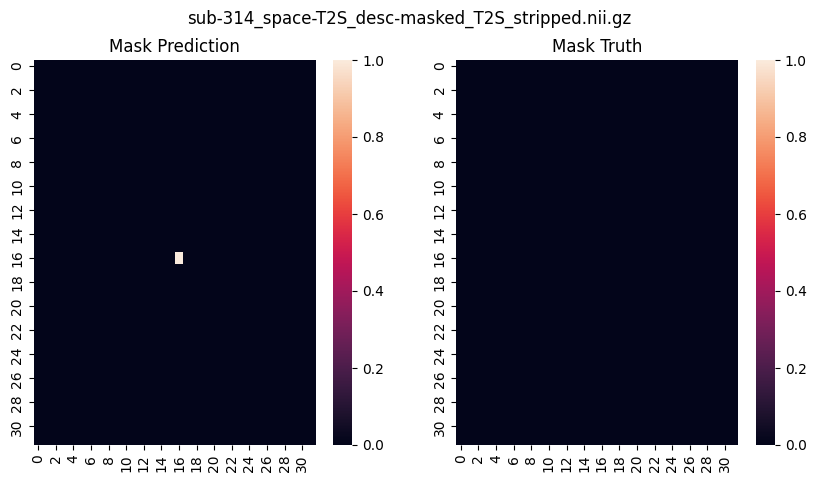

In [47]:
for i in range(4):
    # Prediction and ground truth plotting
    prediction = predictions[i].view(patch_size, patch_size).sigmoid().detach().cpu()
    ground_truth = ground_truths[i].view(patch_size, patch_size).detach().cpu()
    f, a = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(cases[i].split('\\')[-1])
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((prediction > 0.5), ax=ax1, vmax=1)
    sns.heatmap((ground_truth > 0), ax=ax2, vmax=1)